# Uso de uma RNA (CNN) para o diagnóstico de glaucoma #
### Alunos: ###
- Miguel Mendes Luna - 211026501
- Pedro Eduardo - 200026071
- Davy Alves - 202041661

In [8]:
# Importações básicas
import numpy as np
import pandas as pd
import os

# Explorando uma imagem

Fazendo algumas verificações acerca de um exemplo de imagem, tais como seu formato, seu tamanho (resolução), a imagem propriamente dita e uma representação matricial dos seus pixels com base no código RGB.

Formato da imagem: JPEG
Modo da imagem: RGB
Tamanho da imagem (pixels): (3072, 2048)


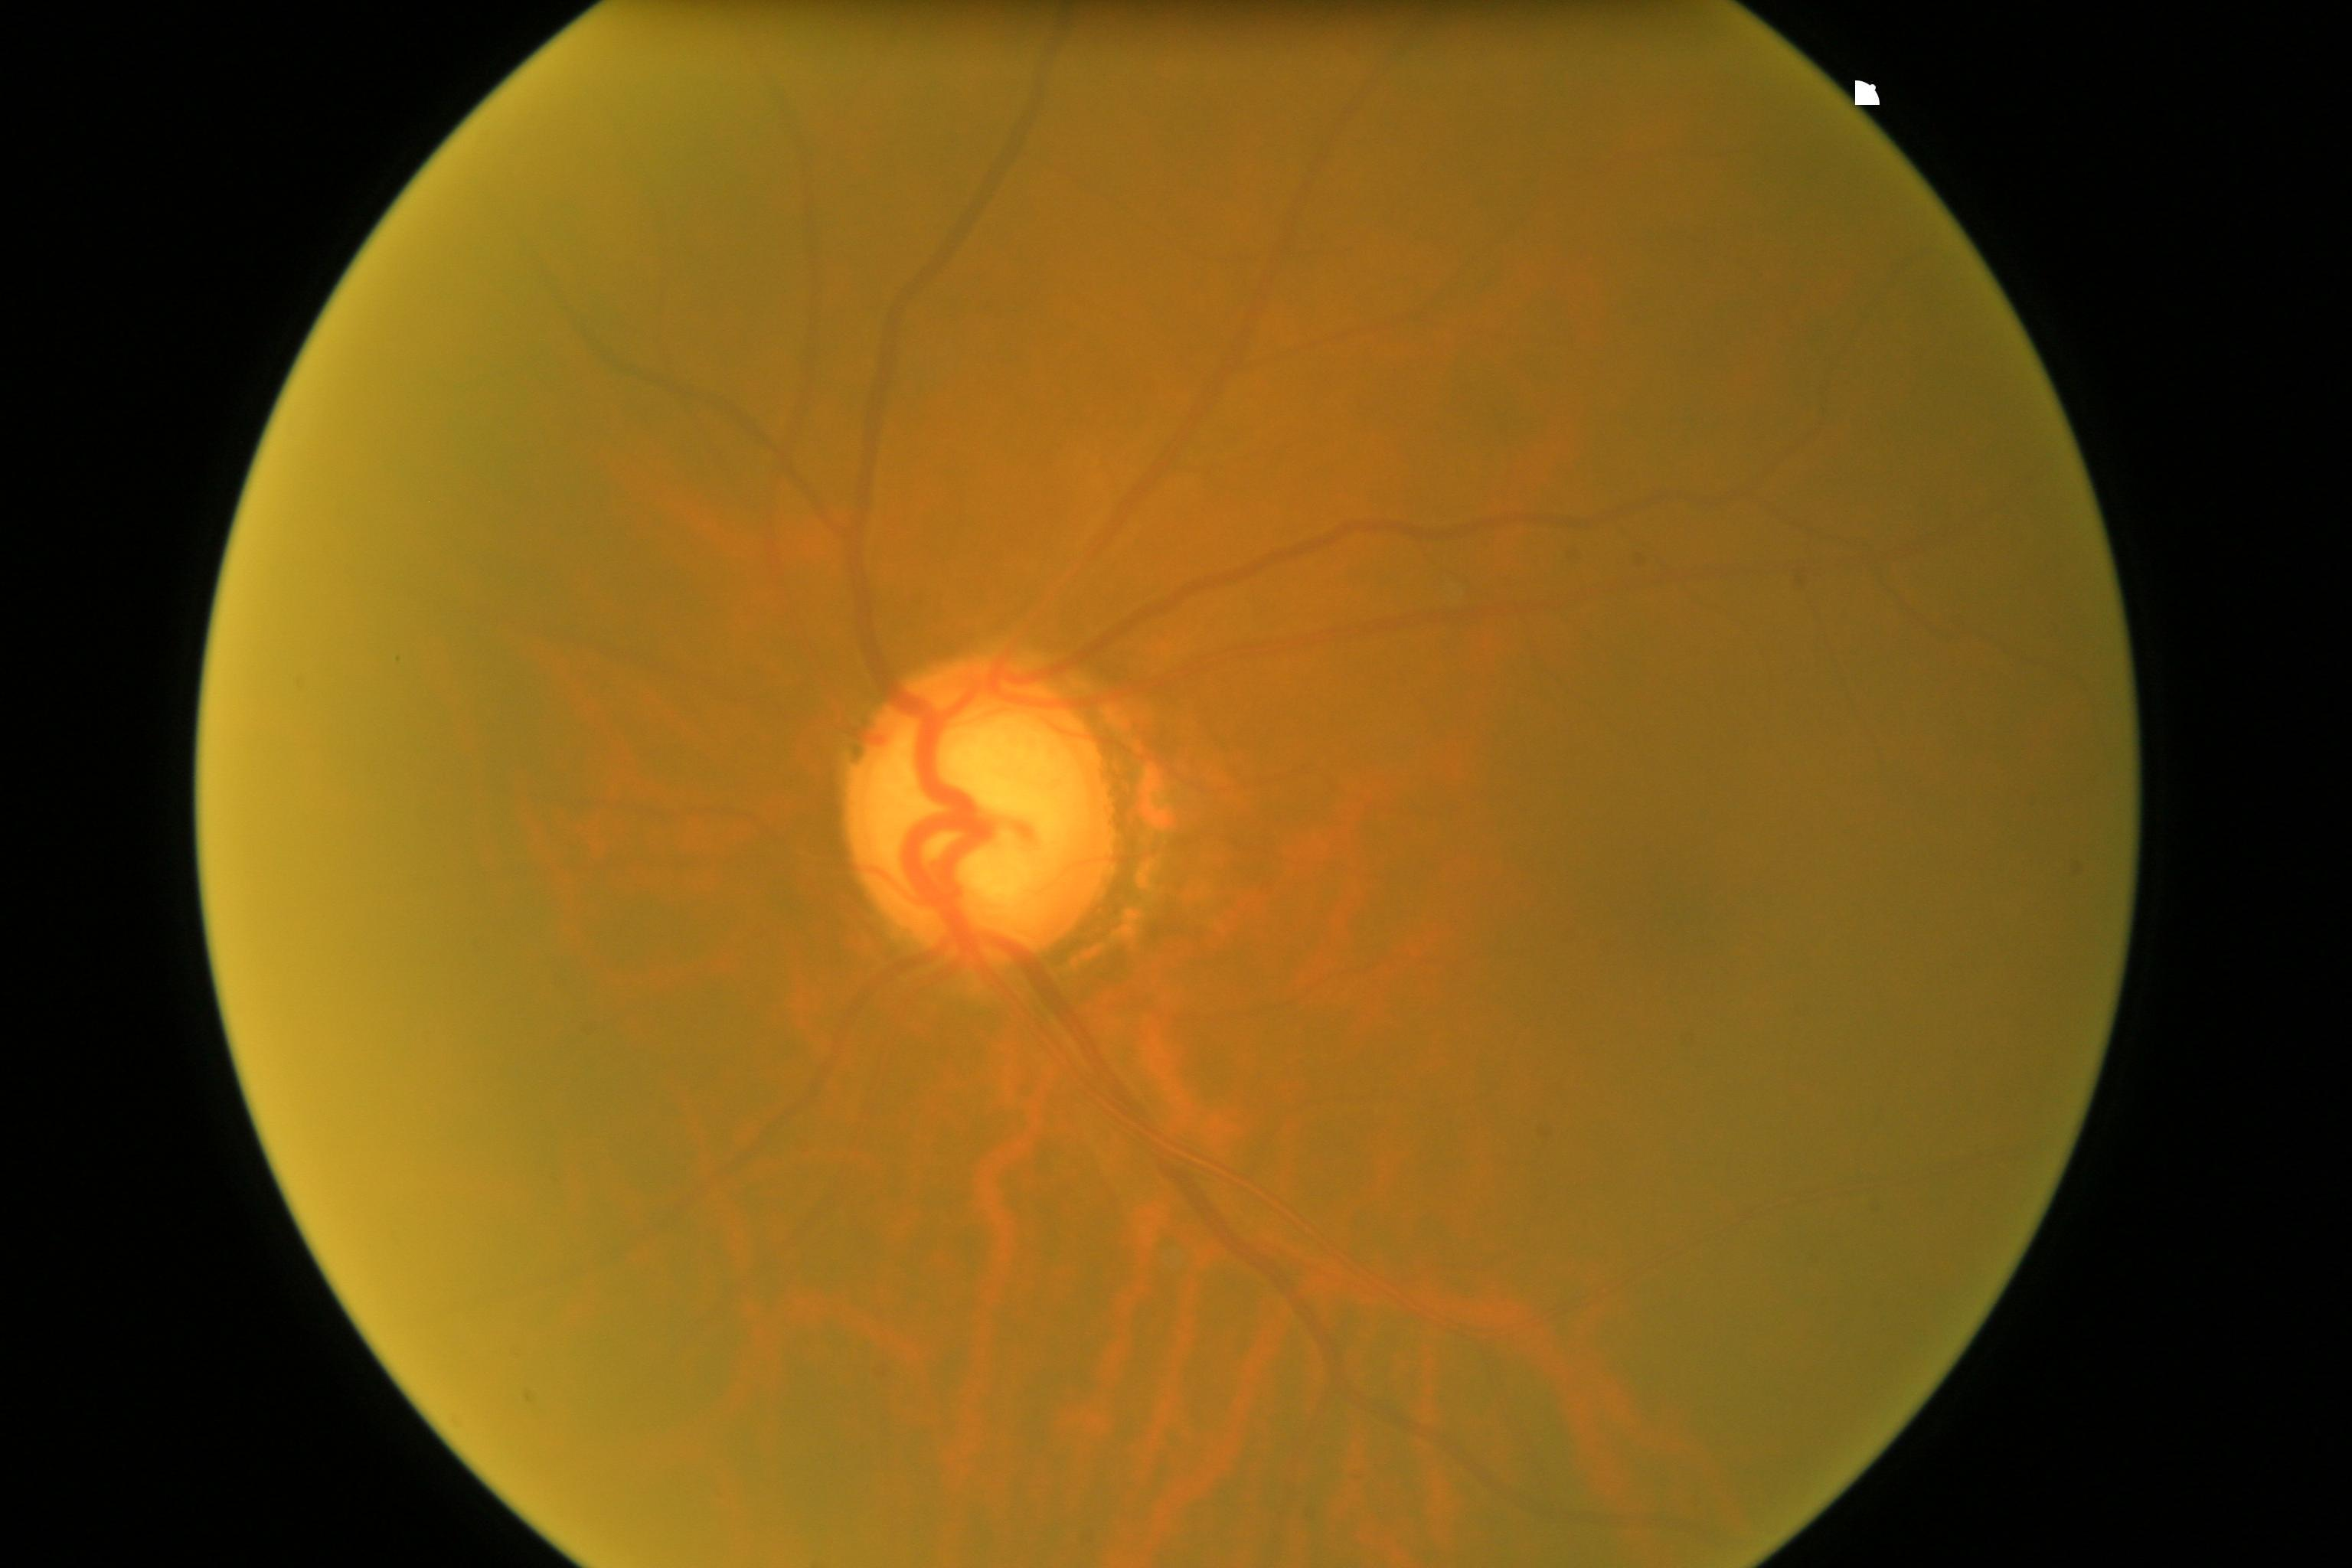

[[[2 2 0]
  [2 2 0]
  [2 2 0]
  ...
  [1 1 0]
  [1 1 0]
  [1 1 0]]

 [[2 2 0]
  [2 2 0]
  [2 2 0]
  ...
  [1 1 0]
  [1 1 0]
  [1 1 0]]

 [[2 2 0]
  [2 2 0]
  [2 2 0]
  ...
  [1 1 0]
  [1 1 0]
  [1 1 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]]


In [9]:
from numpy import asarray

from PIL import Image

# Carregando um exemplo de imagem
image = Image.open('/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Positive/613.jpg') 

# Imprimindo alguns dados acerca da imagem
print("Formato da imagem: " + str(image.format))
print("Modo da imagem: " + str(image.mode))
print("Tamanho da imagem (pixels): " + str(image.size))

# Mostrando a imagem
display(image)

# Mostrando os pixels da imagem matricialmente
pixels = asarray(image)
print(pixels)

# Tratamento de pixels

Aqui é feita a normalização do código RGB dos pixels para que representem um número entre -1 e 1. Note que, inicialmente, é calculada a média geral dos valores correspondentes dos pixels, para então subtraí-la de cada valor, a fim de deixar os valores resultantes "ao redor" de zero, de forma que a média global passou a ser nula. Em seguida, dividiu-se todos os valores correspondentes por 255 (máximo valor no RGB), para que os valores ficassem entre 0 e 1 em módulo.

In [10]:
# global centering

# calculate global mean
mean = pixels.mean()
print('Mean: %.3f' % mean)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# global centering of pixels
pixels = pixels - mean
# confirm it had the desired effect
mean = pixels.mean()
print('Mean: %.3f' % mean)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
print(pixels)


# example of pixel normalization
# confirm pixel range is 0-255
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from integers to floats
pixels = pixels.astype('float32')
# normalize to the range 0-1
pixels /= 255.0
mean = pixels.mean()
print('pixel mean = ', mean)

# confirm the normalization
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
print(pixels)

Mean: 73.460
Min: 0.000, Max: 255.000
Mean: -0.000
Min: -73.460, Max: 181.540
[[[-71.46045897 -71.46045897 -73.46045897]
  [-71.46045897 -71.46045897 -73.46045897]
  [-71.46045897 -71.46045897 -73.46045897]
  ...
  [-72.46045897 -72.46045897 -73.46045897]
  [-72.46045897 -72.46045897 -73.46045897]
  [-72.46045897 -72.46045897 -73.46045897]]

 [[-71.46045897 -71.46045897 -73.46045897]
  [-71.46045897 -71.46045897 -73.46045897]
  [-71.46045897 -71.46045897 -73.46045897]
  ...
  [-72.46045897 -72.46045897 -73.46045897]
  [-72.46045897 -72.46045897 -73.46045897]
  [-72.46045897 -72.46045897 -73.46045897]]

 [[-71.46045897 -71.46045897 -73.46045897]
  [-71.46045897 -71.46045897 -73.46045897]
  [-71.46045897 -71.46045897 -73.46045897]
  ...
  [-72.46045897 -72.46045897 -73.46045897]
  [-72.46045897 -72.46045897 -73.46045897]
  [-72.46045897 -72.46045897 -73.46045897]]

 ...

 [[-73.46045897 -73.46045897 -73.46045897]
  [-73.46045897 -73.46045897 -73.46045897]
  [-73.46045897 -73.46045897 -73

# Visualização parcial

Visualização da imagem original quando comparada à imagem após a normalização dos pixels.

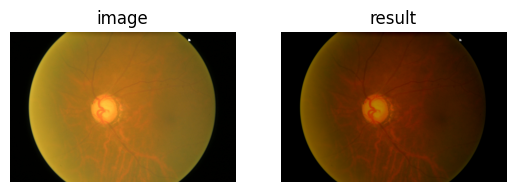

In [11]:
# Visualization
import matplotlib.pyplot as plt
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(image)
ax0.axis('off')
ax0.set_title('image')
ax1.imshow(pixels)
ax1.axis('off')
ax1.set_title('result')
plt.show()

In [12]:
# Declaração de diretórios
TRAIN_DIR = '/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train'
TEST_DIR = '/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'

In [13]:
# Construindo a rede neural

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model 
from keras.optimizers import SGD, Adam
from keras.callbacks import TensorBoard
from keras import metrics
import keras
import matplotlib.pyplot as plt

HEIGHT = 300
WIDTH = 300

BATCH_SIZE = 8
class_list = ["class_1", "class_2"]
FC_LAYERS = [1024, 512, 256]
dropout = 0.5
NUM_EPOCHS = 100
BATCH_SIZE = 8

def build_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # print(fc)
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)
    preditions = Dense(num_classes, activation='sigmoid')(x)
    finetune_model = Model(inputs = base_model.input, outputs = preditions)
    return finetune_model

base_model_1 = ResNet50(weights = 'imagenet',
                       include_top = False,
                       input_shape = (HEIGHT, WIDTH, 3))

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 90,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.1,)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  rotation_range = 90,
                                  horizontal_flip = True,
                                  vertical_flip = False)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size = (HEIGHT, WIDTH),
                                                    batch_size = BATCH_SIZE)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size = (HEIGHT, WIDTH),
                                                  batch_size = BATCH_SIZE)




resnet50_model = build_model(base_model_1,
                                      dropout = dropout,
                                      fc_layers = FC_LAYERS,
                                      num_classes = len(class_list))

adam = Adam(learning_rate = 0.00001)
resnet50_model.compile(adam, loss="binary_crossentropy", metrics=["accuracy", metrics.mean_squared_error, metrics.F1Score, metrics.Recall, metrics.Precision, metrics.FalseNegatives, metrics.FalsePositives])

filepath = "./checkpoints" + "RestNet50" + "_model_weights.keras"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor = ["acc"], verbose= 1, mode = "max")
cb=TensorBoard(log_dir=("/home/ubuntu/"))
callbacks_list = [checkpoint, cb]

# print(train_generator.class_indices)

# resnet50_model.summary()

Found 520 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [14]:
# Treinamento
history = resnet50_model.fit(train_generator, epochs = NUM_EPOCHS, steps_per_epoch = 100, 
                                       shuffle = True, validation_data = test_generator)

Epoch 1/100
  2/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.3750 - f1_score: 0.3651 - false_negatives_1: 12.0000 - false_positives_1: 4.0000 - loss: 2.3236 - mean_squared_error: 0.5264 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 

W0000 00:00:1720088816.834080     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 65/100 ━━━━━━━━━━━━━━━━━━━━ 13s 379ms/step - accuracy: 0.5522 - f1_score: 0.4518 - false_negatives_1: 126.7692 - false_positives_1: 91.0000 - loss: 1.5666 - mean_squared_error: 0.3645 - precision_1: 0.5457 - recall_1: 0.4564

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1720088846.928282     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 60s 403ms/step - accuracy: 0.5730 - f1_score: 0.4614 - false_negatives_1: 166.4000 - false_positives_1: 122.8500 - loss: 1.5359 - mean_squared_error: 0.3543 - precision_1: 0.5668 - recall_1: 0.4851 - val_accuracy: 0.7385 - val_f1_score: 0.4248 - val_false_negatives_1: 33.0000 - val_false_positives_1: 34.0000 - val_loss: 0.7056 - val_mean_squared_error: 0.2134 - val_precision_1: 0.7405 - val_recall_1: 0.7462
Epoch 2/100


W0000 00:00:1720088856.718395     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 270ms/step - accuracy: 0.7066 - f1_score: 0.5107 - false_negatives_1: 137.2400 - false_positives_1: 110.2100 - loss: 1.1894 - mean_squared_error: 0.2735 - precision_1: 0.6667 - recall_1: 0.6257 - val_accuracy: 0.7385 - val_f1_score: 0.4248 - val_false_negatives_1: 26.0000 - val_false_positives_1: 52.0000 - val_loss: 0.7000 - val_mean_squared_error: 0.2214 - val_precision_1: 0.6667 - val_recall_1: 0.8000
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 265ms/step - accuracy: 0.6585 - f1_score: 0.4994 - false_negatives_1: 141.3300 - false_positives_1: 128.6000 - loss: 1.1346 - mean_squared_error: 0.2992 - precision_1: 0.6183 - recall_1: 0.5987 - val_accuracy: 0.7385 - val_f1_score: 0.4248 - val_false_negatives_1: 34.0000 - val_false_positives_1: 37.0000 - val_loss: 0.6319 - val_mean_squared_error: 0.2079 - val_precision_1: 0.7218 - val_recall_1: 0.7385
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 273ms/step - accuracy: 0.7180 - f1_score: 0.5851 - false_negati

In [15]:
#Importacoes
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model_2 = InceptionV3(weights = 'imagenet',
                       include_top = False,
                       input_shape = (HEIGHT, WIDTH, 3))

train_datagen_2 = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 90,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.1,)

test_datagen_2 = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  rotation_range = 90,
                                  horizontal_flip = True,
                                  vertical_flip = False)

train_generator_2 = train_datagen_2.flow_from_directory(TRAIN_DIR,
                                                    target_size = (HEIGHT, WIDTH),
                                                    batch_size = BATCH_SIZE)

test_generator_2 = test_datagen_2.flow_from_directory(TEST_DIR,
                                                  target_size = (HEIGHT, WIDTH),
                                                  batch_size = BATCH_SIZE)

inception_model = build_model(base_model_2,
                                      dropout = dropout,
                                      fc_layers = FC_LAYERS,
                                      num_classes = len(class_list))

filepath = "./checkpoints" + "InceptionV3" + "_model_weights.keras"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor = ["acc"], verbose= 1, mode = "max")
cb=TensorBoard(log_dir=("/home/ubuntu/"))
callbacks_list = [checkpoint, cb]

inception_model.compile(optimizer = Adam(learning_rate = 0.00001), loss="binary_crossentropy", metrics=["accuracy", metrics.mean_squared_error, metrics.F1Score, metrics.Recall, metrics.Precision, metrics.FalseNegatives, metrics.FalsePositives])
#inception_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 520 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [16]:
#Treinamento
history_2 = inception_model.fit(train_generator_2, epochs = NUM_EPOCHS, steps_per_epoch = 100, 
                                       shuffle = True, validation_data = test_generator_2)

Epoch 1/100
  2/100 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8125 - f1_score: 0.4751 - false_negatives_2: 5.0000 - false_positives_2: 4.0000 - loss: 15.2988 - mean_squared_error: 0.3438 - precision_2: 0.6607 - recall_2: 0.6250 

W0000 00:00:1720091857.043078     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 65/100 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step - accuracy: 0.6653 - f1_score: 0.4825 - false_negatives_2: 112.2000 - false_positives_2: 101.4154 - loss: 23.9840 - mean_squared_error: 0.3998 - precision_2: 0.6022 - recall_2: 0.5622

W0000 00:00:1720091885.108580     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 409ms/step - accuracy: 0.6606 - f1_score: 0.4851 - false_negatives_2: 147.4800 - false_positives_2: 139.0700 - loss: 24.0208 - mean_squared_error: 0.3997 - precision_2: 0.5996 - recall_2: 0.5721 - val_accuracy: 0.7385 - val_f1_score: 0.4248 - val_false_negatives_2: 34.0000 - val_false_positives_2: 36.0000 - val_loss: 7.3675 - val_mean_squared_error: 0.2664 - val_precision_2: 0.7273 - val_recall_2: 0.7385
Epoch 2/100


W0000 00:00:1720091897.585269     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 265ms/step - accuracy: 0.6746 - f1_score: 0.4553 - false_negatives_2: 139.2900 - false_positives_2: 132.6600 - loss: 20.7513 - mean_squared_error: 0.3781 - precision_2: 0.6209 - recall_2: 0.6095 - val_accuracy: 0.7385 - val_f1_score: 0.4248 - val_false_negatives_2: 34.0000 - val_false_positives_2: 34.0000 - val_loss: 6.1177 - val_mean_squared_error: 0.2615 - val_precision_2: 0.7385 - val_recall_2: 0.7385
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 267ms/step - accuracy: 0.6315 - f1_score: 0.4872 - false_negatives_2: 141.4900 - false_positives_2: 155.0000 - loss: 21.8854 - mean_squared_error: 0.4172 - precision_2: 0.5764 - recall_2: 0.5995 - val_accuracy: 0.7385 - val_f1_score: 0.4248 - val_false_negatives_2: 35.0000 - val_false_positives_2: 34.0000 - val_loss: 5.6156 - val_mean_squared_error: 0.2620 - val_precision_2: 0.7364 - val_recall_2: 0.7308
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 262ms/step - accuracy: 0.6617 - f1_score: 0.5184 - false_nega

In [17]:
# Evaluate the resnet model
resnet_evaluation = resnet50_model.evaluate(test_generator)
resnet_evaluation

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.7356 - f1_score: 0.4728 - false_negatives_1: 20.2222 - false_positives_1: 20.2222 - loss: 0.5074 - mean_squared_error: 0.1727 - precision_1: 0.7356 - recall_1: 0.7356


[0.5436895489692688,
 0.7153846025466919,
 0.1860564947128296,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.8325791 , 0.05128203], dtype=float32)>,
 0.7153846025466919,
 0.7153846025466919,
 37.0,
 37.0]

In [18]:
# Evaluate the inception model
inception_evaluation = inception_model.evaluate(test_generator_2)
inception_evaluation

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.7371 - f1_score: 0.4242 - false_negatives_2: 19.6667 - false_positives_2: 19.6667 - loss: 0.6140 - mean_squared_error: 0.2110 - precision_2: 0.7371 - recall_2: 0.7371


[0.6134422421455383,
 0.7384615540504456,
 0.210666686296463,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.8495575, 0.       ], dtype=float32)>,
 0.7384615540504456,
 0.7384615540504456,
 34.0,
 34.0]

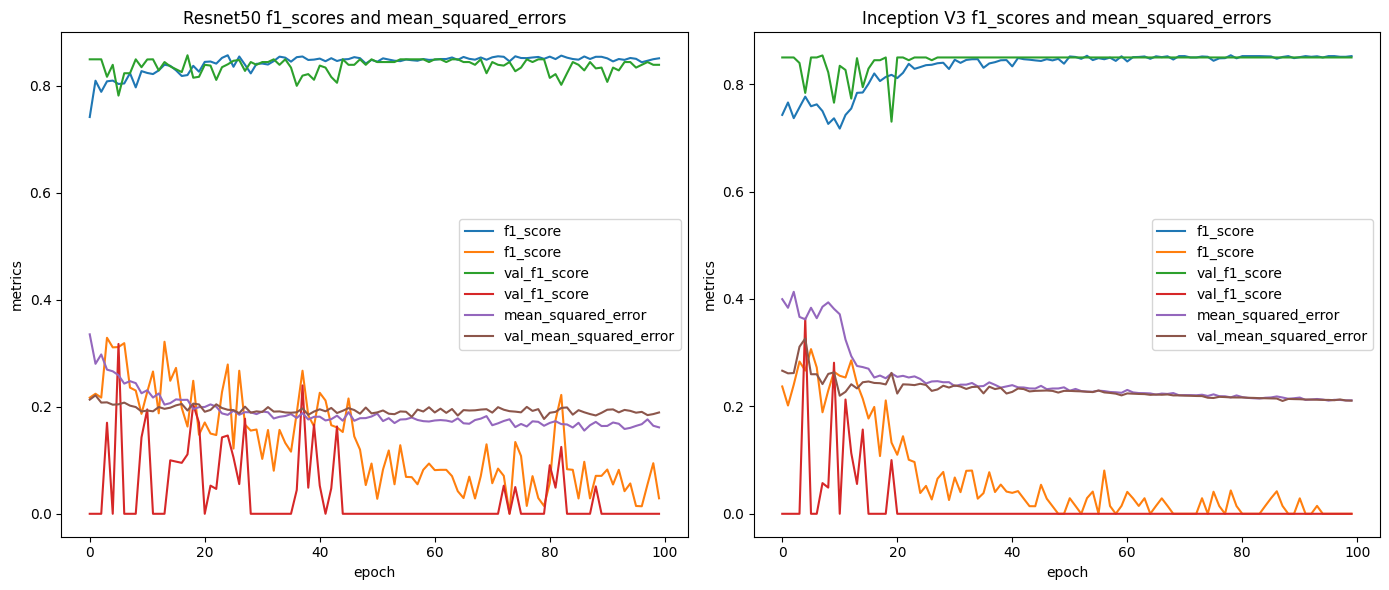

In [19]:
# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# f1_score resnet50 history
ax1.plot(history.history['f1_score'])
ax1.plot(history.history['val_f1_score'])
ax1.plot(history.history['mean_squared_error'])
ax1.plot(history.history['val_mean_squared_error'])
ax1.set_title('Resnet50 f1_scores and mean_squared_errors')
ax1.set_ylabel('metrics')
ax1.set_xlabel('epoch')
ax1.legend(['f1_score', 'f1_score', 'val_f1_score', 'val_f1_score', 'mean_squared_error', 'val_mean_squared_error'], loc='center right')

# f1_score inception v3 history
ax2.plot(history_2.history['f1_score'])
ax2.plot(history_2.history['val_f1_score'])
ax2.plot(history_2.history['mean_squared_error'])
ax2.plot(history_2.history['val_mean_squared_error'])
ax2.set_title('Inception V3 f1_scores and mean_squared_errors')
ax2.set_ylabel('metrics')
ax2.set_xlabel('epoch')
ax2.legend(['f1_score', 'f1_score', 'val_f1_score', 'val_f1_score', 'mean_squared_error', 'val_mean_squared_error'], loc='center right')

# Show the plots
plt.tight_layout()
plt.show()

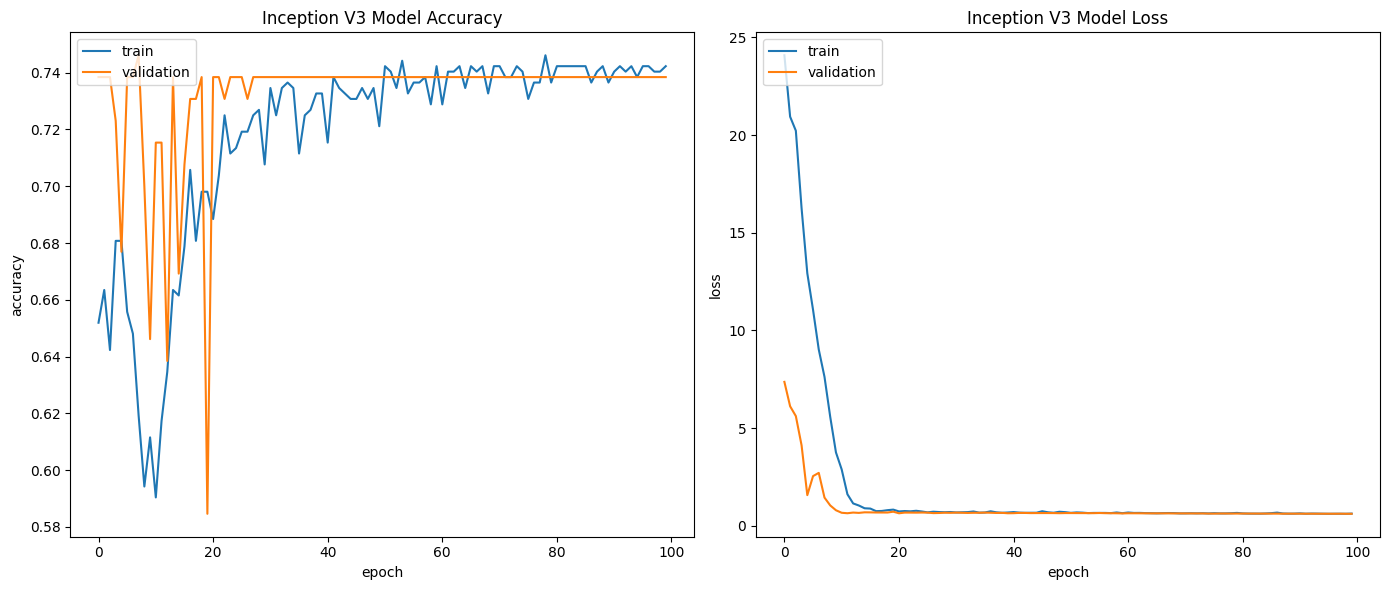

In [20]:
# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy history
ax1.plot(history_2.history['accuracy'])
ax1.plot(history_2.history['val_accuracy'])
ax1.set_title('Inception V3 Model Accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')

# Loss history
ax2.plot(history_2.history['loss'])
ax2.plot(history_2.history['val_loss'])
ax2.set_title('Inception V3 Model Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()

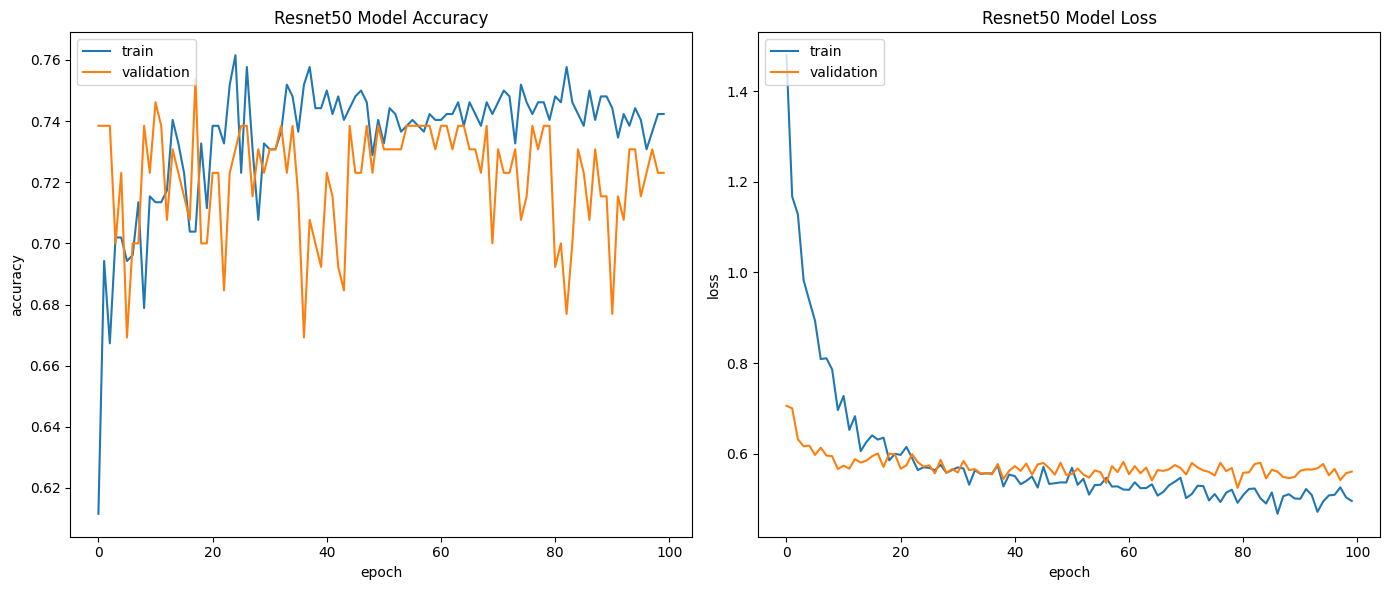

In [21]:
# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy history
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Resnet50 Model Accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')

# Loss history
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Resnet50 Model Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()